In [138]:
# read from csv file
import numpy as np
import pandas as pd
import io
import requests
import datetime
from dateutil import relativedelta

In [105]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [106]:
df = pd.read_csv('churn_homework - homework_orders.csv', infer_datetime_format=True)

In [107]:
df.head()

order_id           source            date_purchased shipping_type  \
0  47433960           iosapp  2019-03-13T08:02:07.000Z      Delivery   
1  47434359           iosapp  2019-03-13T08:11:38.000Z      Delivery   
2  47437194  partner_website  2019-03-13T09:07:31.000Z      Delivery   
3  47442942  partner_website  2019-03-13T11:01:04.000Z      Delivery   
4  47443107  partner_website  2019-03-13T11:04:56.000Z      Delivery   

  payment_method  promo_value  restaurant_total       customer  shops_id  \
0         credit            0             15.50 13315067198.00     24597   
1         credit            0             24.83 15557129447.00     64392   
2           cash            0             43.24 25689365012.00     33699   
3         credit            0             27.95 25421112251.00     19002   
4         credit            0             23.15 18529185191.00     34911   

  state  postal_code  
0    MD        21162  
1    NY        12944  
2    NJ         8007  
3    WI        53235  
4    MA         2122

### Cleaning data

In [108]:
# There are 5 missing customer IDs in total dataset removing those and converting to integer
df = df[~df.customer.isna()]
df['customer'] = df.customer.astype(np.int64)

In [109]:
# There are 52 states missing. It's simpler to filter them out as it is a minimal compared to dataset size
df = df[~df.state.isna()]

In [110]:
# Converting date_purchased field from string to datetime object
df = df[~df.date_purchased.isna()]
df['date_purchased'] = pd.to_datetime(df['date_purchased'])

In [111]:
df = df[df.source.isin(['iosapp', 'partner_website', 'slicelife', 'androidapp'])].copy()

In [112]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title = 'Churn homework dataset', explorative=True)
profile

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Cohort analysis

In [113]:
df['date_purchased_month'] = df['date_purchased'].apply(lambda x: datetime.date(x.year, x.month, 1))

In [148]:
# Cohort month is the first month customer made the purchase
df['cohort_month'] = df.groupby('customer')['date_purchased_month'].transform('min')

In [143]:
# Sanity Check(point)
df.sample(n=5)[['date_purchased', 'date_purchased_month', 'cohort_month']]

date_purchased date_purchased_month cohort_month
4406  2019-06-01 15:11:43+00:00           2019-06-01   2019-05-01
26486 2020-01-28 09:46:14+00:00           2020-01-01   2020-01-01
15360 2019-10-20 14:01:47+00:00           2019-10-01   2019-07-01
28475 2020-02-10 11:57:31+00:00           2020-02-01   2019-10-01
28742 2020-02-12 16:16:03+00:00           2020-02-01   2019-11-01

Below we are calculating the months difference between the purchase date and cohort_month to find cohort index for our analysis

In [144]:
def get_months_diff(row):
    """ Finds the months difference between two dates
        We'll use as cohort index

    """
    return relativedelta.relativedelta(row['date_purchased_month'], row['cohort_month']).months + 1

In [145]:
df['cohort_index'] = df.apply(lambda x: get_months_diff(x), axis=1)

In [147]:
# Sanity check
df.sample(n=5)[['date_purchased_month', 'cohort_month', 'cohort_index']]

date_purchased_month cohort_month  cohort_index
36515           2020-04-01   2019-05-01            12
571             2019-03-01   2019-03-01             1
22149           2019-12-01   2019-11-01             2
21643           2019-12-01   2019-12-01             1
22492           2019-12-01   2019-03-01            10

### Count monthly active customers for each cohort

In [155]:
df \
    .groupby(['cohort_month', 'cohort_index'])['customer'] \
    .apply(pd.Series.nunique) \
    .reset_index() \
    .pivot(index='cohort_month',
           columns='cohort_index',
           values='customer')

cohort_index      1      2      3      4      5      6      7      8      9   \
cohort_month                                                                   
2019-03-01    656.00 289.00 253.00 185.00 189.00 170.00 153.00 161.00 159.00   
2019-04-01    664.00 234.00 162.00 148.00 128.00 136.00 129.00 113.00 113.00   
2019-05-01    738.00 176.00 134.00 136.00 135.00 118.00 111.00 108.00  98.00   
2019-06-01    681.00 177.00 142.00 123.00 105.00 106.00 124.00 103.00  96.00   
2019-07-01    825.00 253.00 170.00 168.00 151.00 144.00 137.00 115.00 118.00   
2019-08-01    796.00 178.00 165.00 135.00 141.00 126.00 126.00 112.00  99.00   
2019-09-01    635.00 202.00 150.00 138.00 130.00 123.00  95.00  98.00  52.00   
2019-10-01    708.00 202.00 158.00 129.00 141.00 106.00 117.00  49.00    NaN   
2019-11-01    901.00 260.00 209.00 197.00 175.00 145.00  80.00    NaN    NaN   
2019-12-01    806.00 264.00 261.00 193.00 174.00  87.00    NaN    NaN    NaN   
2020-01-01    859.00 390.00 273.00 265.00 106.00    NaN    NaN    NaN    NaN   
2020-02-01    997.00 465.00 310.00 189.00    NaN    NaN    NaN    NaN    NaN   
2020-03-01   1021.00 616.00 246.00    NaN    NaN    NaN    NaN    NaN    NaN   
2020-04-01      5.00   3.00    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2020-05-01      3.00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

cohort_index     10     11     12  
cohort_month                       
2019-03-01   154.00 151.00 139.00  
2019-04-01   106.00 106.00  92.00  
2019-05-01    91.00 100.00  92.00  
2019-06-01    97.00  90.00  44.00  
2019-07-01   120.00  55.00    NaN  
2019-08-01    53.00    NaN    NaN  
2019-09-01      NaN    NaN    NaN  
2019-10-01      NaN    NaN    NaN  
2019-11-01      NaN    NaN    NaN  
2019-12-01      NaN    NaN    NaN  
2020-01-01      NaN    NaN    NaN  
2020-02-01      NaN    NaN    NaN  
2020-03-01      NaN    NaN    NaN  
2020-04-01      NaN    NaN    NaN  
2020-05-01      NaN    NaN    NaN

Let's convert this one to a function where we optionally can choose the cohort based on an attribute

In [162]:
list(df['shipping_type'].unique())

['Delivery', 'Pickup']

In [284]:
import pandas as pd
import datetime
from dateutil import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,8))

def cohortify_retention(df: pd.DataFrame, 
                        count_col: str, 
                        time_col: str, 
                        cohort_interval:str = 'month',
                        visualize=True,
                        label=''
                       ) -> pd.DataFrame:
    """Create Cohort table (pivot table)  for a given pandas dataframe and interval
    
    df: pandas Dataframe
    count_col: This is the column we will count the customers/subscriptions..etc (cannot be NA)
    time_col: This is the column for the puchase/activation..etc datetime column (must be datettime object)
    cohort_interval: Cohort frequency, day, month.. etc. (currently supports month only)
    visualize: plot cohort heatmap,
    label='Add Title to the graph'
    """
    if cohort_interval.lower() != 'month':
        raise ValueError('Currently only supported value is `month`')
    
    # New col names
    date_begin = f"{time_col}_{cohort_interval}"
    cohort_begin = f'cohort_{cohort_interval}'
    
    # Find the first date for the month
    df[date_begin] = df[time_col].apply(lambda x: datetime.date(x.year, x.month, 1))
    
    # Cohort month is the first month customer made the purchase
    df[cohort_begin] = df.groupby(count_col)[date_begin].transform('min')
    
    # funct to calc month difference between puchase date and cohort begin
    f = lambda row: relativedelta.relativedelta(row[date_begin], row[cohort_begin]).months + 1
    
    # find cohort index
    df['cohort_index'] = df.apply(f, axis=1)

    # create pivot table
    pivoted= df \
        .groupby([cohort_begin, 'cohort_index'])[count_col] \
        .apply(pd.Series.nunique) \
        .reset_index() \
        .pivot(index=cohort_begin,
           columns='cohort_index',
           values=count_col)
    
    cohort_sizes = pivoted.iloc[:, 0]

        
    percented = pivoted.divide(cohort_sizes, axis=0)*100
    
    if visualize:
        
        plt.figure(figsize=(10,8))
        plt.title(f'Retention rates {label}')
        ax = sns.heatmap(
            data=percented, 
            annot=True,
            fmt='2.2f',
        )
        try:
            ax.set_yticklabels(c.index.strftime('%Y-%m'))
        except ValueError:
            pass
        
        percented.T.plot(figsize=(14,8))
        plt.title(f'Cohorts: User Retention {label}')
        # plt.xticks(np.arange(1, 12.1, 1))
        # plt.xlim(1, 12)
        plt.ylabel('% of Cohort Purchasing');
        
    return percented

<Figure size 720x576 with 0 Axes>

In [247]:

def cohortify_avg_metric(df: pd.DataFrame, 
                         metric_col: str, 
                         time_col: str, 
                         cohort_interval:str = 'month',
                         visualize: bool=True,
                         label=''
                        ) -> pd.DataFrame:
    """Create Cohort table (pivot table)  for a given pandas dataframe and interval
    
    df: pandas Dataframe
    metric_col: This is the column we will calculate the areage quantity of teh given clumn such as price (cannot be NA)
    time_col: This is the column for the puchase/activation..etc datetime column (must be datettime object)
    cohort_interval: Cohort frequency, day, month.. etc. (currently supports month only)
    """
    if cohort_interval.lower() != 'month':
        raise ValueError('Currently only supported value is `month`')
    
    # New col names
    date_begin = f"{time_col}_{cohort_interval}"
    cohort_begin = f'cohort_{cohort_interval}'
    
    # Find the first date for the month
    df[date_begin] = df[time_col].apply(lambda x: datetime.date(x.year, x.month, 1))
    
    # Cohort month is the first month customer made the purchase
    df[cohort_begin] = df.groupby('customer')[date_begin].transform('min')
    
    # funct to calc month difference between puchase date and cohort begin
    f = lambda row: relativedelta.relativedelta(row[date_begin], row[cohort_begin]).months + 1
    
    # find cohort index
    df['cohort_index'] = df.apply(f, axis=1)

    # create pivot table
    pivoted= df \
        .groupby([cohort_begin, 'cohort_index'])[metric_col] \
        .mean() \
        .reset_index() \
        .pivot(index=cohort_begin,
           columns='cohort_index',
           values=metric_col) \
        .round(3)
    
    if visualize:
        
        plt.figure(figsize=(10,8))
        plt.title(f'Retention rates {label}')
        ax = sns.heatmap(
            data=pivoted, 
            annot=True,
            fmt='2.2f',
        )
        ax.set_yticklabels(c.index.strftime('%Y-%m'))
        
    return pivoted

### Below is the customer retention rate cohort

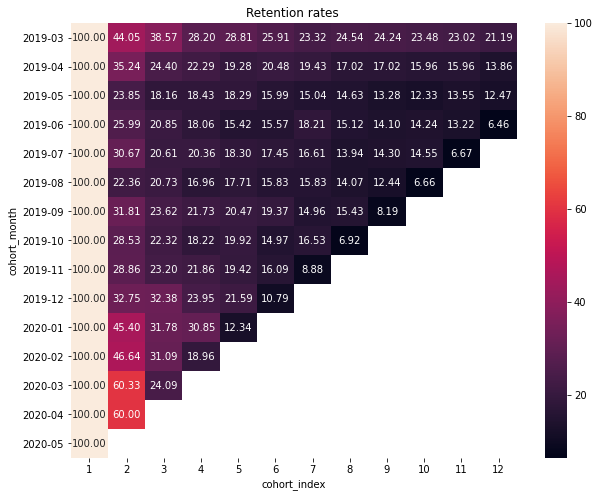

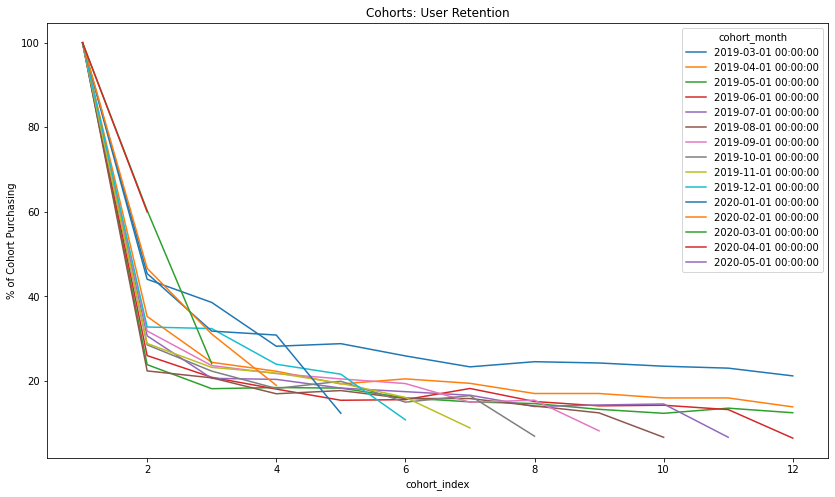

In [263]:
res = cohortify_retention(df, count_col='customer', time_col='date_purchased', cohort_interval='month')

Customer retention seems stronger in 2020 in general, it is worth exploring the possible reasons for that. Is there any promotion in 2020 different than 2019, or is it simply because coronavirus made people to order more often therefore naturally retention is stronger. 

### Let's have a look at for average `restaurant_total` amount cohort

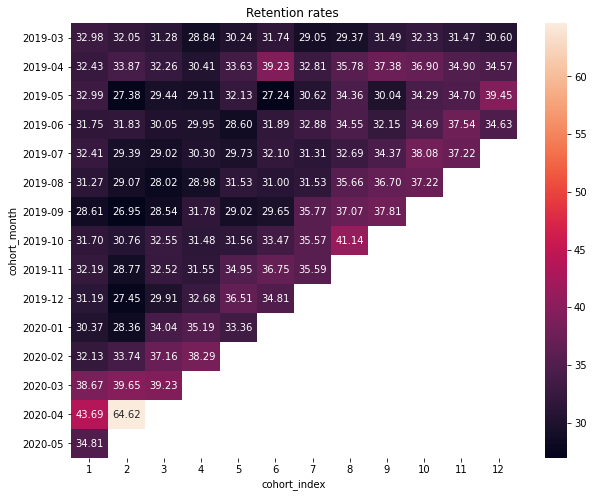

In [249]:
res =cohortify_avg_metric(df, metric_col='restaurant_total', time_col='date_purchased', cohort_interval='month')

Looks like average restaurant earnings are mostly stable, for retained customer. Though there is a tendency to increase towords to latest months in each cohort. Is that the coronavirus effect, maybe people ordering more food after Feb 2020? 

## finding first order characterictics

In [793]:
df['rank'] = df.groupby("customer")["date_purchased"].rank("dense", ascending=True)
# separate dimentions for first orders
dims = df[df['rank'] == 1.0][['customer', 'source', 'shipping_type', 'payment_method', 'state', 'promo_value']]
# list of orders without dimentions
orders = df[['customer', 'order_id', 'date_purchased', 'restaurant_total', 'cohort_month']]
df_rank1 = orders.merge(dims, how = 'left', on = 'customer')

## `shipping_type` cohort

In [787]:
# Create sub cohorts by attributes

def cohortify_retention_by(df, attribute,  **kwargs):
    """ Look at cohorts by attribute
    
    """
    facets = list(df[attribute].unique())

    for facet in facets:
        df_faceted = df[df[attribute] == facet].copy()
        cohortify_retention(df_faceted, count_col='customer', time_col='date_purchased', 
                            cohort_interval='month', visualize=True, label=facet.upper())
    

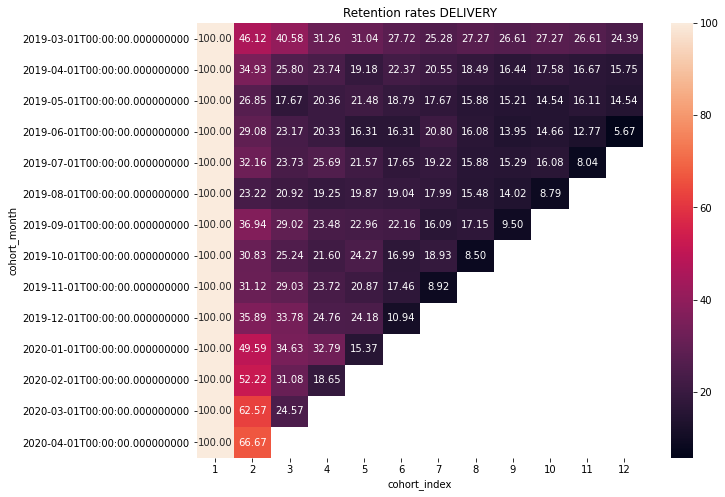

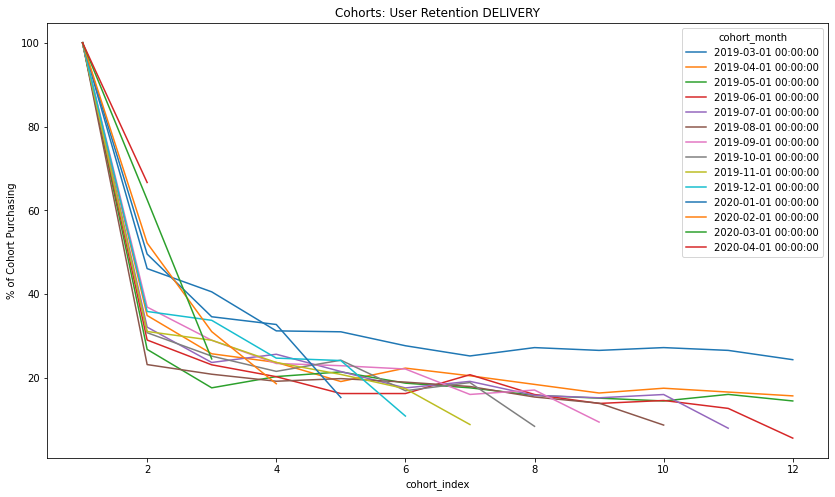

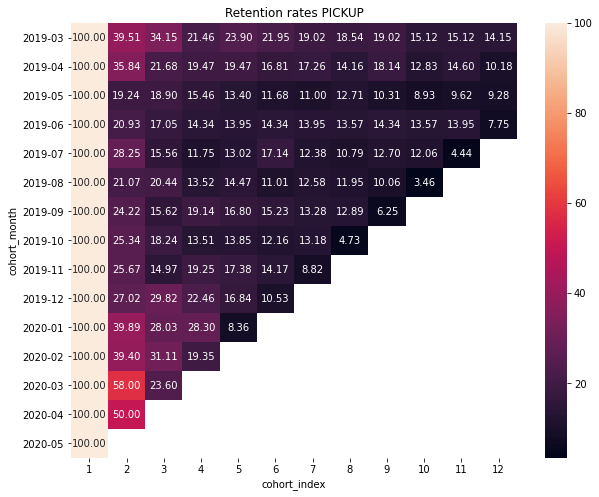

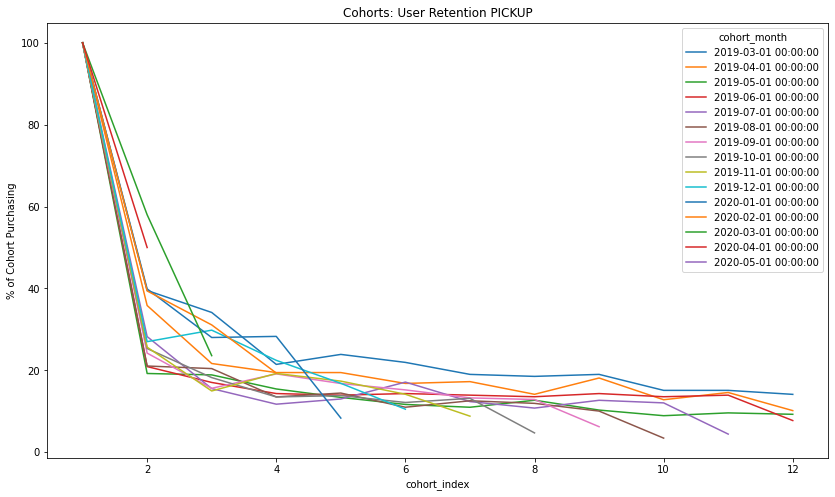

In [788]:
cohortify_retention_by(df_rank1, 'shipping_type')

## `source` cohort

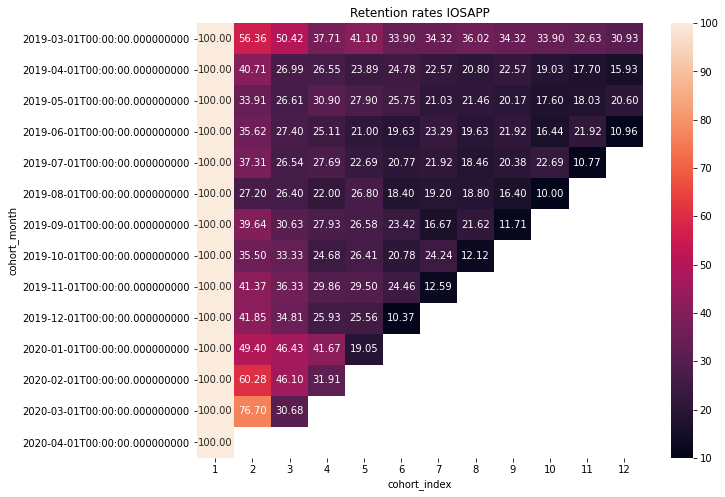

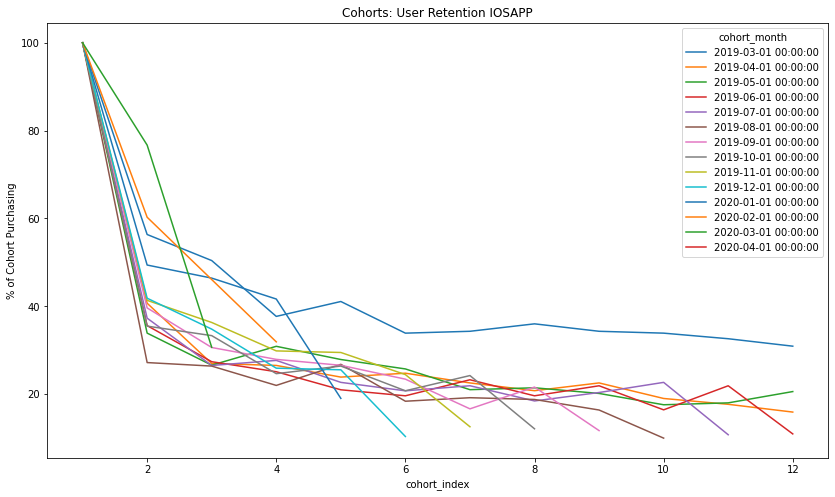

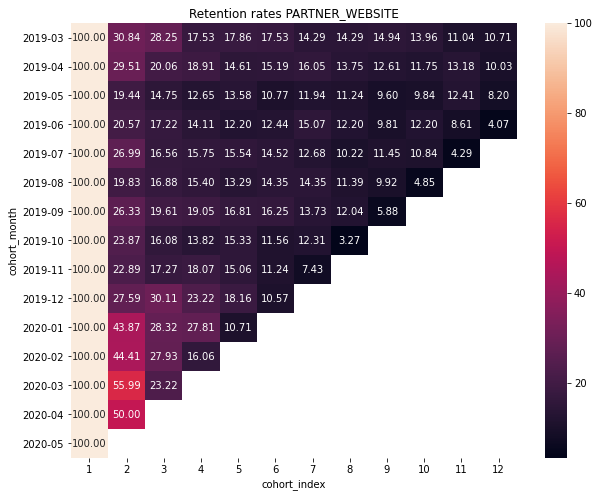

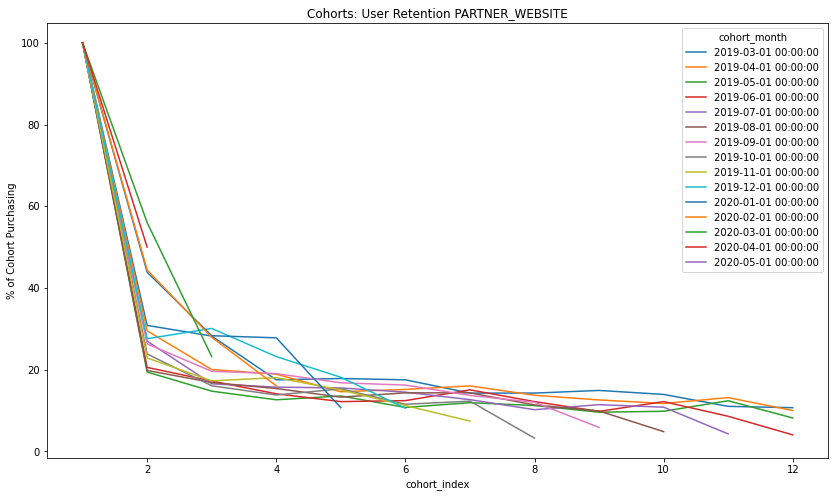

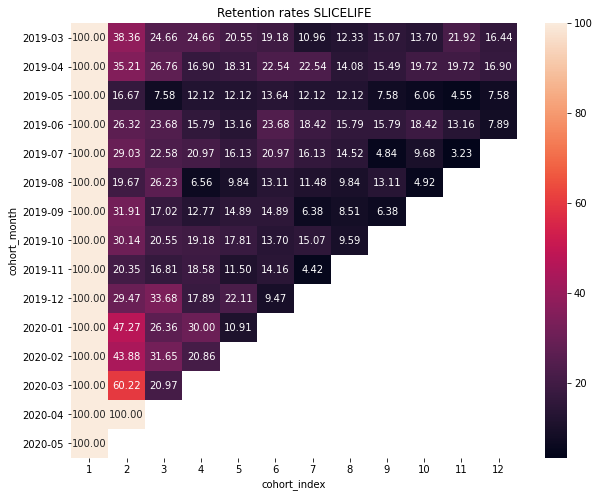

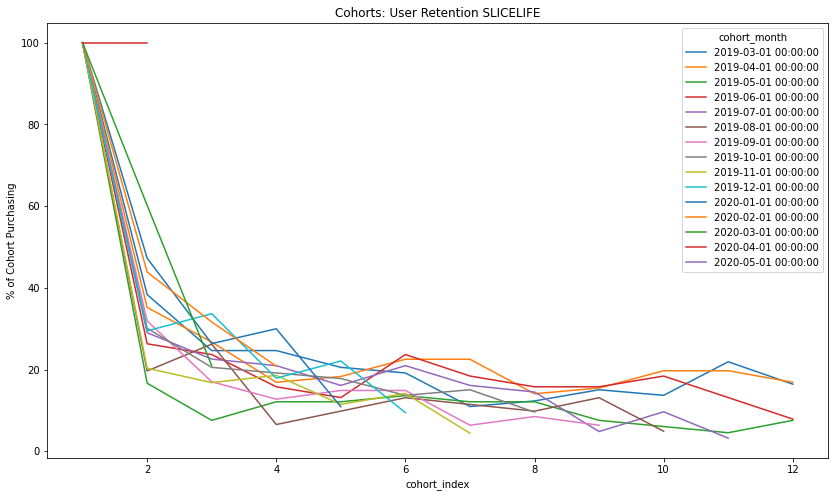

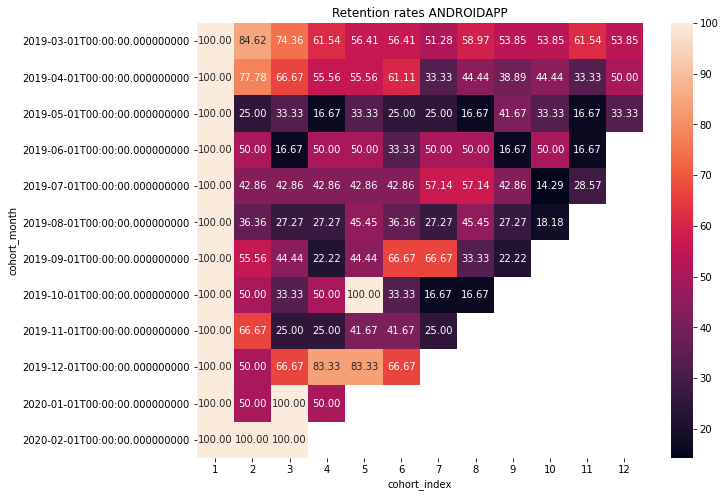

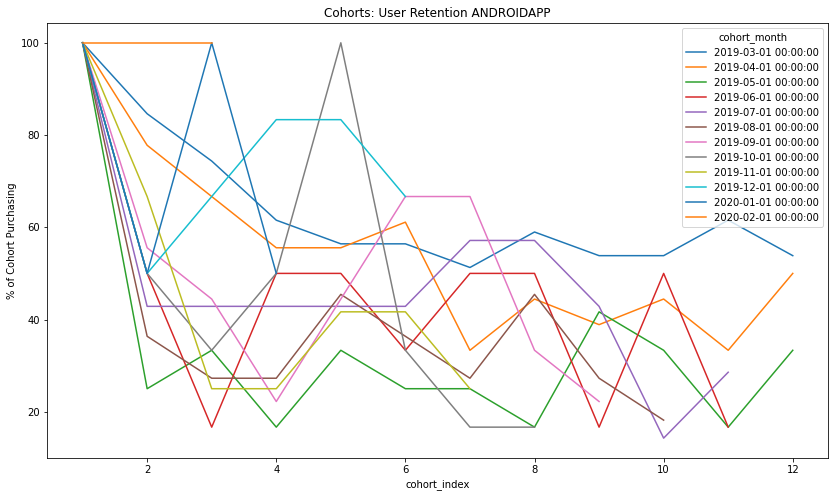

In [789]:
cohortify_retention_by(df_rank1, 'source')

## `payment_method` cohort

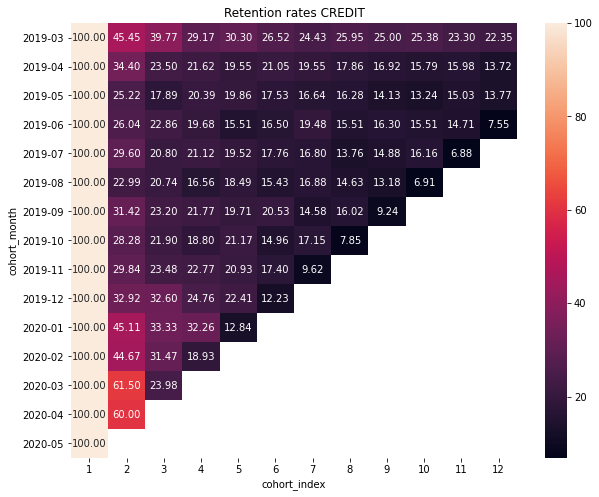

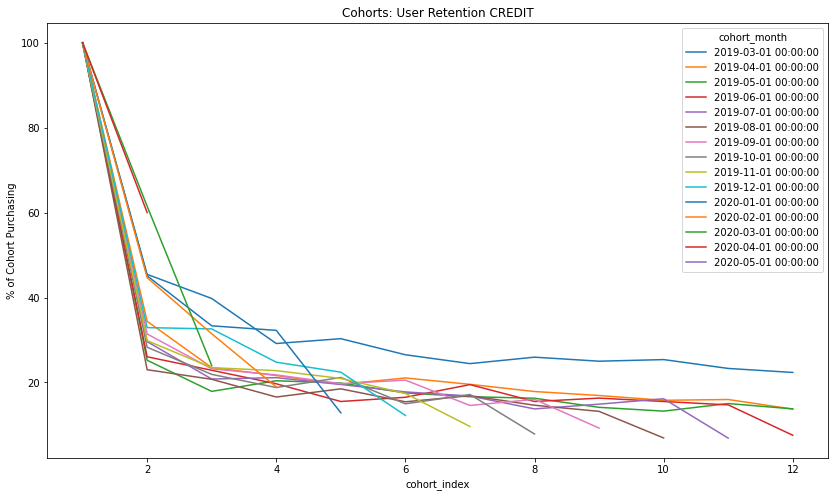

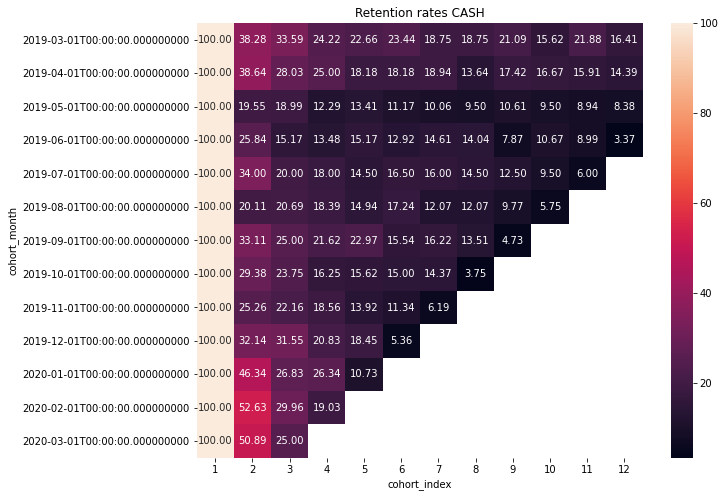

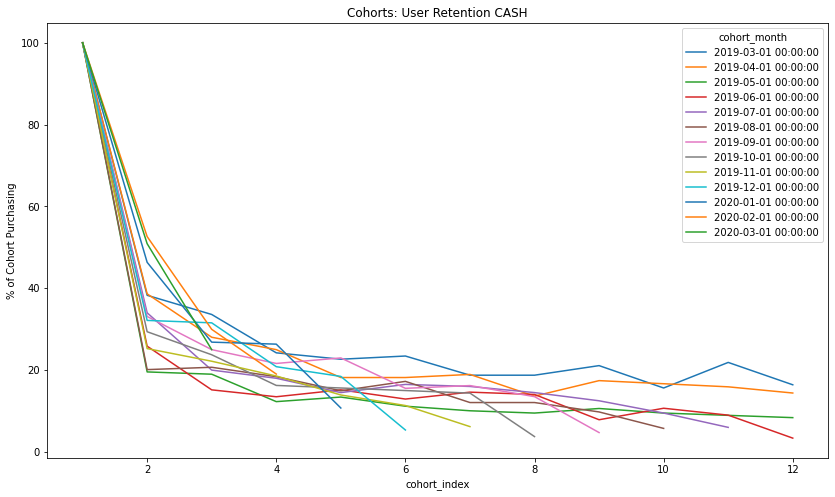

In [790]:
cohortify_retention_by(df_rank1, 'payment_method')

## `state` cohort.
Since there are many states we'll only look at the top 5

In [791]:
top5 =  df.state.value_counts().head()
df_state = df_rank1[df_rank1.state.isin(top5.index)]

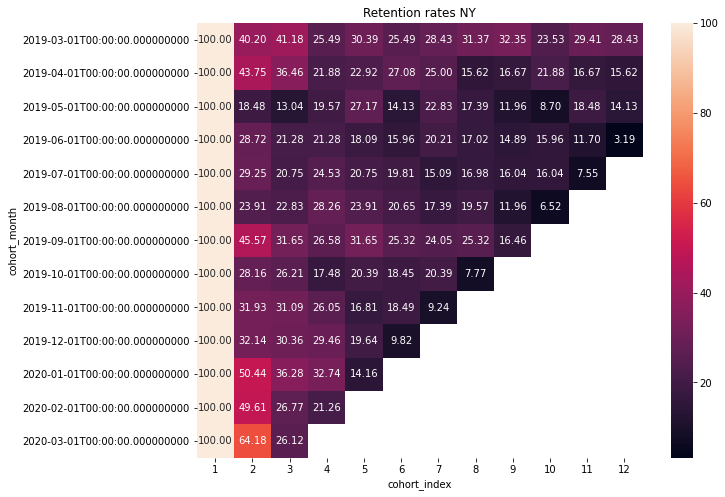

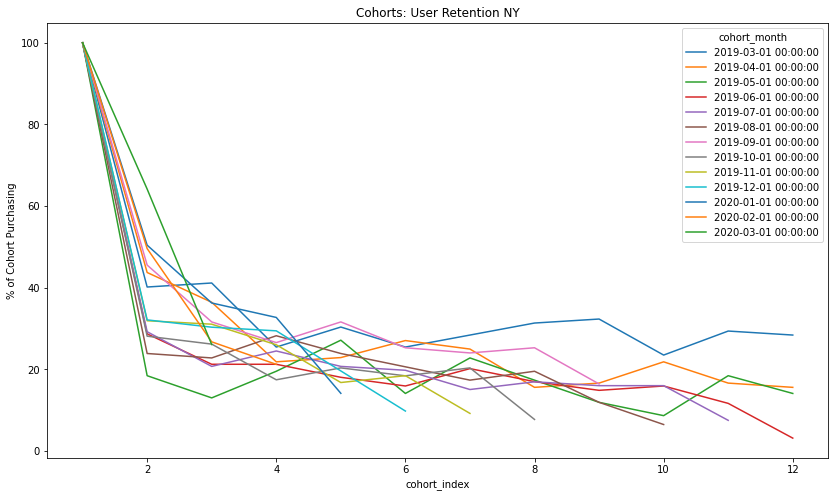

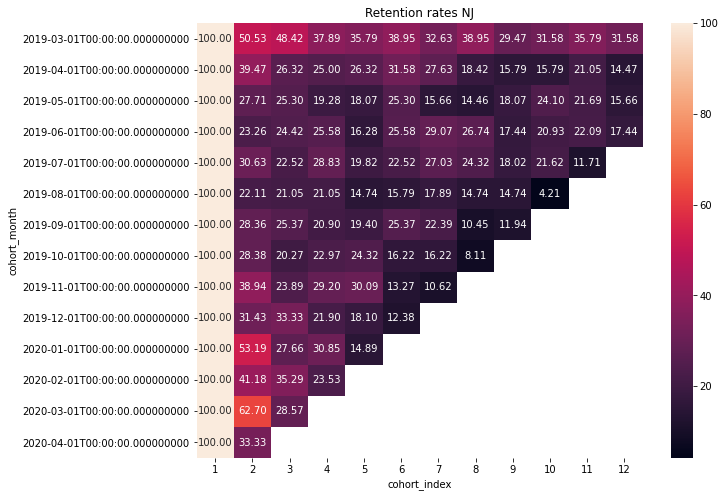

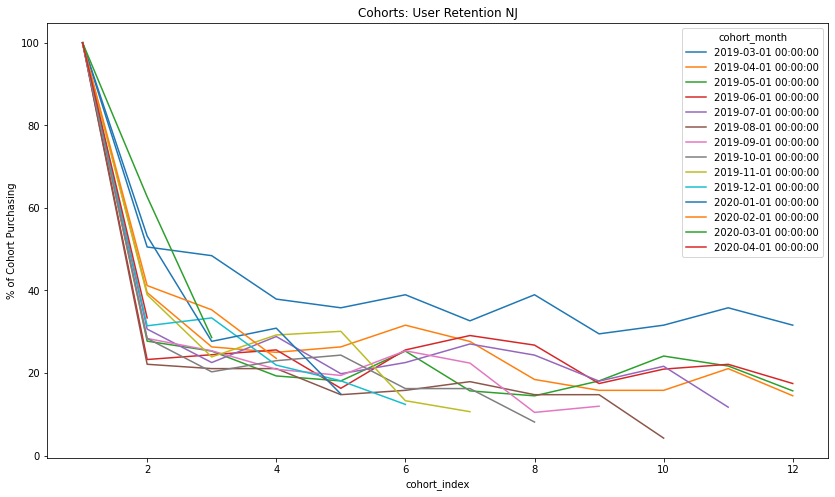

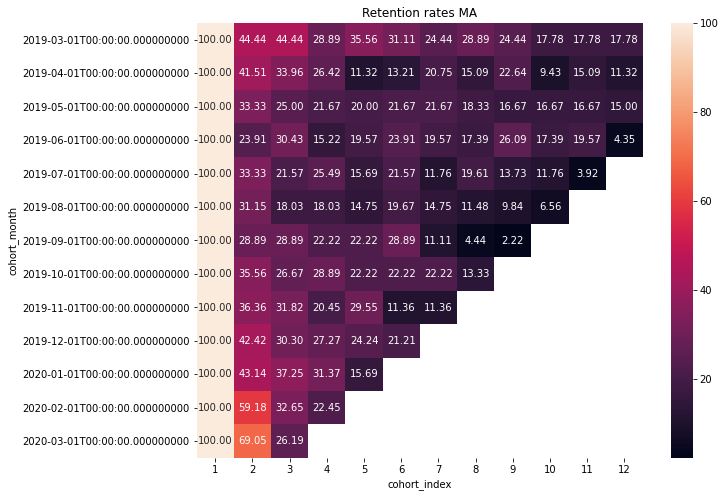

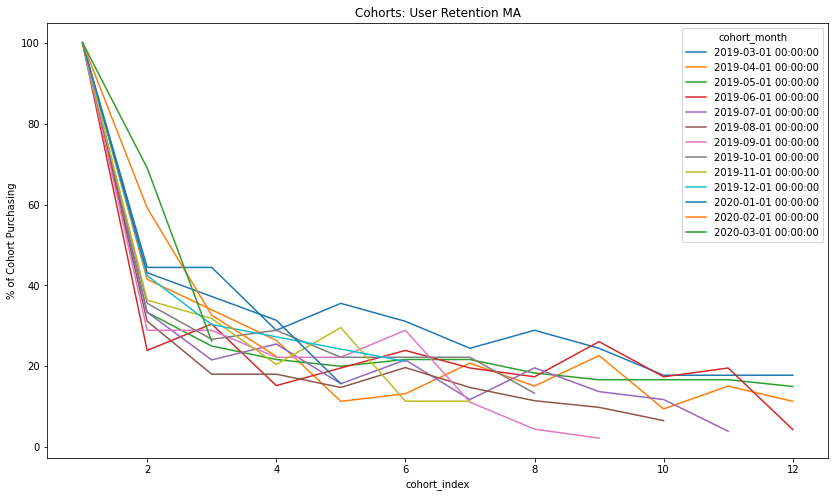

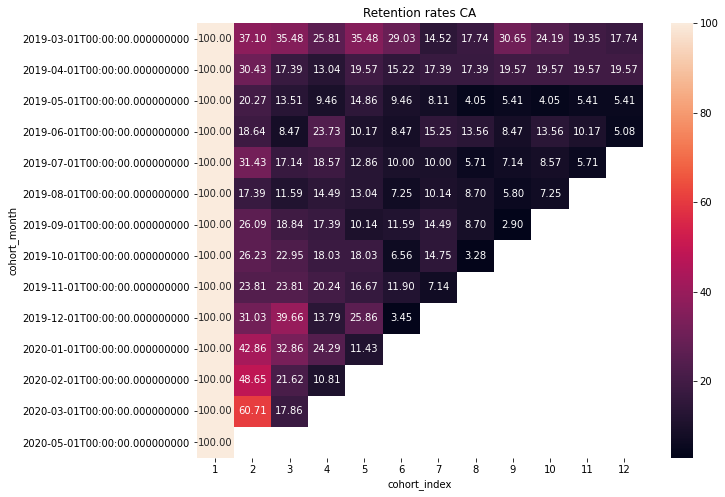

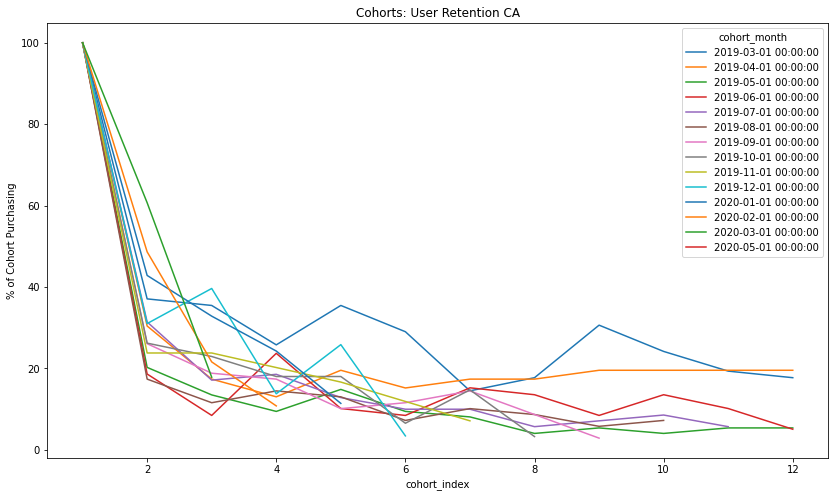

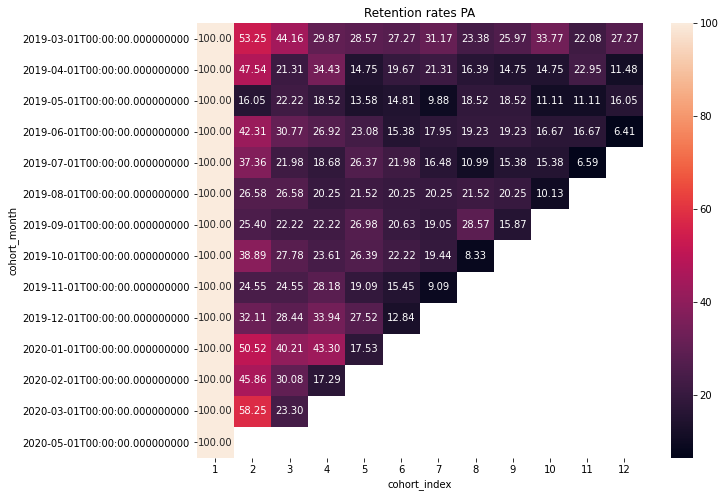

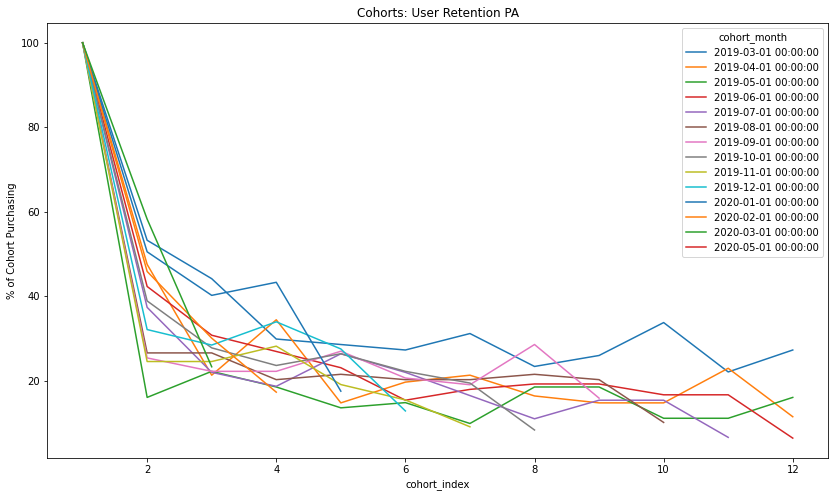

In [792]:
cohortify_retention_by(df_state, 'state')

# First order characteristics

## Retention by promo values

In [795]:
df_rank1['date_purchased_as_date'] = df_rank1['date_purchased'].dt.date
df_rank1.set_index('customer', inplace=True)
df_rank1['first_order_date'] =  df_rank1.groupby(level=0)['date_purchased_as_date'].min().apply(lambda x: x.replace(day=1))
df_rank1.reset_index(inplace=True)

In [796]:
df_rank1

customer  order_id            date_purchased  restaurant_total  \
0      13315067198  47433960 2019-03-13 08:02:07+00:00             15.50   
1      15557129447  47434359 2019-03-13 08:11:38+00:00             24.83   
2      25689365012  47437194 2019-03-13 09:07:31+00:00             43.24   
3      25421112251  47442942 2019-03-13 11:01:04+00:00             27.95   
4      18529185191  47443107 2019-03-13 11:04:56+00:00             23.15   
...            ...       ...                       ...               ...   
41396  21987304103  86341470 2020-05-11 17:56:49+00:00             26.64   
41397  25716360551  86341677 2020-05-11 17:58:48+00:00             18.59   
41398   9610001087  86343333 2020-05-11 18:17:20+00:00             44.44   
41399  18074100113  86346324 2020-05-11 19:07:33+00:00             32.33   
41400  13316188268  86346558 2020-05-11 19:13:14+00:00             20.65   

      cohort_month           source shipping_type payment_method state  \
0       2019-03-01           iosapp      Delivery         credit    MD   
1       2019-03-01           iosapp      Delivery         credit    NY   
2       2019-03-01  partner_website      Delivery           cash    NJ   
3       2019-03-01  partner_website      Delivery         credit    WI   
4       2019-03-01  partner_website      Delivery         credit    MA   
...            ...              ...           ...            ...   ...   
41396   2019-09-01           iosapp      Delivery         credit    NJ   
41397   2020-03-01  partner_website        Pickup         credit    MA   
41398   2019-12-01  partner_website      Delivery         credit    MN   
41399   2020-02-01  partner_website        Pickup         credit    AZ   
41400   2020-01-01  partner_website      Delivery           cash    MD   

       promo_value date_purchased_as_date first_order_date  
0                0             2019-03-13       2019-03-01  
1                0             2019-03-13       2019-03-01  
2                0             2019-03-13       2019-03-01  
3                0             2019-03-13       2019-03-01  
4                0             2019-03-13       2019-03-01  
...            ...                    ...              ...  
41396            4             2020-05-11       2019-09-01  
41397            0             2020-05-11       2020-03-01  
41398            0             2020-05-11       2019-12-01  
41399            0             2020-05-11       2020-02-01  
41400            0             2020-05-11       2020-01-01  

[41401 rows x 12 columns]

In [797]:
df2 = df_rank1.copy()

In [833]:
# if customer ordered again after 90 days since first order consider them retained

# find difference
df2['days_from_first_order'] = (df2['date_purchased_as_date']-df2['first_order_date']).dt.days

# find max diff in days between first and last order
df2.set_index('customer', inplace=True)
df2['days_from_first_order_max'] = df2.groupby(level=0)['days_from_first_order'].max().apply(lambda x: x)
df2.reset_index(inplace=True)

# if order days ago > 90 consider a customer retained
#df2['is_retained'][df2.order_days_ago_max >= 90] = True
#df2['is_retained'][df2.order_days_ago_max < 90] = False
df2.loc[df2.days_from_first_order_max >= 90, 'is_retained'] = True
df2.loc[df2.days_from_first_order_max < 90, 'is_retained'] = False
# remove all customers who ordered after January 2020 
df2 = df2[df2['first_order_date'] < datetime.date(2020, 2, 1)]

In [834]:
df2[df2.customer == 15557129447]

customer  order_id            date_purchased  restaurant_total  \
1      15557129447  47434359 2019-03-13 08:11:38+00:00             24.83   
2347   15557129447  51096912 2019-04-30 09:06:45+00:00             48.27   
15823  15557129447  66144213 2019-10-29 13:34:07+00:00             40.86   
33627  15557129447  79444470 2020-03-19 12:44:58+00:00             12.26   
35313  15557129447  80522070 2020-03-29 12:58:54+00:00             26.61   

      cohort_month  source shipping_type payment_method state  promo_value  \
1       2019-03-01  iosapp      Delivery         credit    NY            0   
2347    2019-03-01  iosapp      Delivery         credit    NY            0   
15823   2019-03-01  iosapp      Delivery         credit    NY            0   
33627   2019-03-01  iosapp      Delivery         credit    NY            0   
35313   2019-03-01  iosapp      Delivery         credit    NY            0   

      date_purchased_as_date first_order_date  days_from_first_order  \
1                 2019-03-13       2019-03-01                     12   
2347              2019-04-30       2019-03-01                     60   
15823             2019-10-29       2019-03-01                    242   
33627             2020-03-19       2019-03-01                    384   
35313             2020-03-29       2019-03-01                    394   

       days_from_first_order_max is_retained  
1                            394        True  
2347                         394        True  
15823                        394        True  
33627                        394        True  
35313                        394        True

In [835]:
# count retained customers per promo value
retained = df2[df2['is_retained'] == True].groupby(['promo_value'])['customer'].nunique()
retained

promo_value
0    3353
1     129
2     114
3     129
4     124
5      63
Name: customer, dtype: int64

In [837]:
# count total customers per promo value
total_customers = df2.groupby(['promo_value'])['customer'].nunique()
print(total_customers)

promo_value
0    7240
1     235
2     235
3     237
4     210
5     112
Name: customer, dtype: int64


In [838]:
# retention rate per promo value
promo_retention_rate = (retained/total_customers)*100
print(promo_retention_rate)

promo_value
0   46.31
1   54.89
2   48.51
3   54.43
4   59.05
5   56.25
Name: customer, dtype: float64


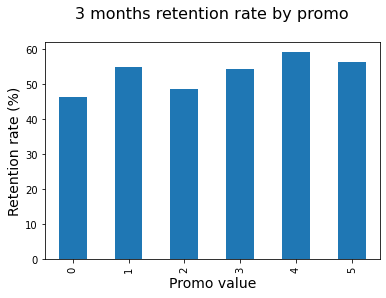

In [839]:
import matplotlib.pyplot as plt
# Create a bar chart 
promo_retention_rate.plot(kind = 'bar')
# Add a title and x and y-axis labels
plt.title('3 months retention rate by promo\n', size = 16)
plt.xlabel('Promo value', size = 14)
plt.ylabel('Retention rate (%)', size = 14)
# Display the plot
plt.show()

## Retention by promo value over time

In [840]:
# calculate retention rate over time
# count retained customers per promo value
retained = df2[df2['is_retained'] == True].groupby(['promo_value', 'first_order_date'])['customer'].nunique()
#print(retained)

# count total customers per promo value
total_customers = df2.groupby(['promo_value', 'first_order_date'])['customer'].nunique()
#print(total_customers)

# retention rate per promo value
promo_retention_rate1 = (retained/total_customers)*100
promo_retention_rate1 = promo_retention_rate1.unstack(level=0)

promo_retention_rate1

promo_value          0     1     2     3     4     5
first_order_date                                    
2019-03-01       59.57 50.00 25.00 58.33 66.67 50.00
2019-04-01       56.25 61.11 43.75 70.59 53.85 62.50
2019-05-01       49.32 85.71 42.86 56.52 84.62 50.00
2019-06-01       50.00 58.82 46.67 80.00 47.06 73.33
2019-07-01       49.24 47.37 61.76 54.17 47.06 80.00
2019-08-01       47.16 54.55 41.67 45.45 54.17 16.67
2019-09-01       48.60 54.55 53.12 68.18 75.00 66.67
2019-10-01       42.36 36.36 31.25 31.82 65.38 61.54
2019-11-01       39.01 56.67 69.57 55.56 42.31 40.91
2019-12-01       39.69 56.76 31.03 38.24 60.53 53.85
2020-01-01       34.24 46.15 64.71 70.00 75.00 60.00

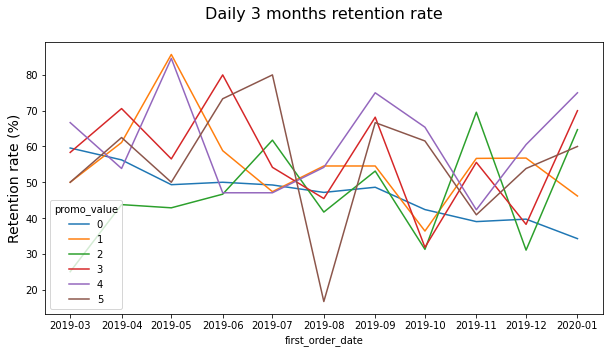

In [841]:

promo_retention_rate1.plot(figsize=(10,5))
plt.title('Daily 3 months retention rate\n', size = 16)
plt.ylabel('Retention rate (%)', size = 14)
plt.show()

## Testing Promo Code Effectiveness

Remember the plot about retention rate by promo. `0` Means no promo code, and the others are simply dollar value (discount) 

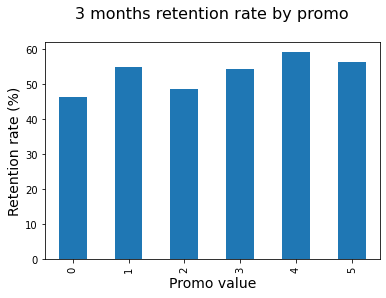

In [842]:
# Create a bar chart 
promo_retention_rate.plot(kind = 'bar')
# Add a title and x and y-axis labels
plt.title('3 months retention rate by promo\n', size = 16)
plt.xlabel('Promo value', size = 14)
plt.ylabel('Retention rate (%)', size = 14)
# Display the plot
plt.show()

By looking at chart, customers without promo code, less likely to retain 3 months time. Between promo values there doesn't seem to be big difference on retention impact but 4 and 5 have higher customer retention rate. However we better quantify this one more rigorously. 

Our methodology is as following:

- We'll be using hypothesis testing to create a null hypothesis
    - There is no difference of retention rate between two given groups. Differences can be explained by chance. 
- Alternative hypothesis is that there is a meaningful difference between two given groups. 

since we have 6 promo values we need to test choice(6,2) = 15 groups. 

Before going forward we choose a p value of 0.05

We can use t-test if we want to solve this analytically (if conditions are satisfied). But here we prefer a computational approach as it is generally much easier to reason and code. 

We'll be using bootstrapping, for example let's say we choose to test promo code 0 and 1 respectively. According to our null hypothesis there is no difference. It means if we shuffle the `is_retained` labels the shuffled retention rates should have no impact. 


In [843]:
# Let's filter only customers with promo code 0 and 1 (when they first joined)
ready_for_bootstrap = df2[['customer','promo_value', 'is_retained']].reset_index(drop=True).drop_duplicates()

group_0_1 = ready_for_bootstrap[ready_for_bootstrap.promo_value.isin([0, 1])].copy().reset_index(drop=True)

In [844]:
group_0_1.shape

(7475, 3)

In [845]:
# Let's see a sample of data frame
group_0_1.sample(5)

customer  promo_value is_retained
4870  27588228032            0        True
340   21099840776            0       False
6127  22039938986            0       False
4904  27445316348            0        True
6381  18940690136            0        True

There are 9480 rows in the table. To shuffle all the labels, we will draw a random sample of 9480 rows without replacement. Then the sample will include all the rows of the table, in random order.

In [847]:
shuffled_label = group_0_1.sample(n=7475, replace=False, random_state=42)['promo_value'].reset_index(drop=True)

In [848]:
group_0_1['shuffled_label'] =shuffled_label

In [849]:
group_0_1.sample(n=10, random_state=3)

customer  promo_value is_retained  shuffled_label
2377  12471668852            0       False               0
4431  21980667125            0        True               1
2864  21735761564            0       False               0
2047   6216174020            0       False               0
1227  18306371273            0       False               0
6257  29136369449            0       False               0
6993  18322186889            0        True               0
3375  15494243579            0       False               0
6449  27217520522            0       False               0
331   29366840138            0        True               0

For each `is_retained` row there is a label in the column Shuffled Label, while original label is in `promo_value`. If the null hypothesis is true, all the random re-arrangements of the labels should be equally likely.

Let’s see how different the retenation rate are in the two randomly labeled groups.

In [850]:
group_0_1_temp = group_0_1.replace({'is_retained': {True: 1, False: 0}})

In [851]:
diff = group_0_1_temp.groupby('shuffled_label')['is_retained'].mean()
diff

shuffled_label
0   0.47
1   0.45
Name: is_retained, dtype: float64

In [852]:
(diff.values[0] - diff.values[1])*100

1.5234512754202456

Looks like promo group has retention rate (for 3 months) is 0.4 whereas for non promo group it is 0.39. There is a small difference ~(1.5%) after our shuffling. But let's check this difference before we shuffle. 

In [853]:
diff =group_0_1_temp.groupby('promo_value')['is_retained'].mean()
diff 

promo_value
0   0.46
1   0.55
Name: is_retained, dtype: float64

In [854]:
(diff.values[0] - diff.values[1])*100

-8.581462325144

In original group this difference is much more obvious. non promo group has 38% retention rate whereas if $1 promo offered when the customer uses promo in his/her first order then he/she likely to retain by 54%

Let's turn this one to a function, as we'll use it later. 

In [855]:
def difference_of_retention_rates(original_and_shuffled, retention_col, label):
    """Calculate the retention rate difference between to groups 
    """
    df = original_and_shuffled.replace({retention_col: {True: 1, False: 0}})
    difference = df.groupby(label)[retention_col].mean()
    
    return difference.values[0] -difference.values[1]
    
    

In [856]:
difference_of_retention_rates(group_0_1, retention_col='is_retained', label='shuffled_label')

0.015234512754202456

As seen above it is ~0.015 which is 10 times less than original difference. Can this original difference be explained by chance alone? 

We will also need to do shuffling many times, therefore let's define as a function

In [857]:
def shuffle_it(df, original_label_col, retention_col):
    n = df.shape[0]
    df['shuffled_label'] = df.sample(n=n, replace=False)[original_label_col].reset_index(drop=True)
    return df

We've seen above that one shuffling resulted in 1.5% difference, but could a different shuffle have resulted in a larger difference between the group retention rate differences? To get a sense of the variability, we must simulate the difference many times.

We will start by defining a function that simulates one value of the test statistic under the null hypothesis. This is just a matter of collecting the code that we wrote above. But because we will later want to use the same process for comparing means of other variables, we will define a function that takes three arguments:

- dataframe contains the data
- the label of the column that contains the numerical variable (retention_col = `is_retained`, 0 or 1) 
- the label of the column that contains the Boolean variable for grouping (original_label_col = promo_values)

It returns the difference between the retention difference of two groups formed by randomly shuffling all the labels.

In [858]:
def one_simulated_difference(df, original_label_col, retention_col):
    shuffled_table = shuffle_it(df, original_label_col, retention_col)
    return difference_of_retention_rates(shuffled_table, retention_col, label='shuffled_label')   

In [859]:
one_diff = group_0_1[['customer', 'promo_value', 'is_retained']]

In [860]:
one_simulated_difference(df=one_diff, original_label_col='promo_value', retention_col='is_retained')

0.041595156929587374

## Permutation Test

Tests based on random permutations of the data are called permutation tests. We are performing one in this example. In the cell below, we will simulate our test statistic – the difference between the retention rate of the two groups – many times and collect the differences in an array.

In [861]:
differences = np.zeros(5000)

In [862]:

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference(df=one_diff, original_label_col='promo_value', retention_col='is_retained')
    differences[i] = new_difference 

In [863]:
result = pd.Series(differences)

<AxesSubplot:title={'center':'Distribution of retention rate differences'}, ylabel='Frequency'>

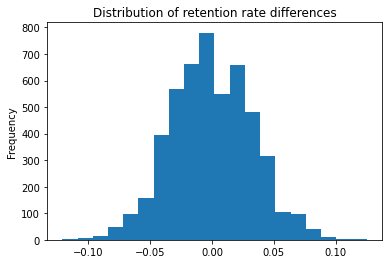

In [864]:
result.plot(kind='hist', title='Distribution of retention rate differences', bins=20 )


Notice how the distribution is centered around 0. This makes sense, because under the null hypothesis the two groups should have roughly the same average. Therefore the difference between the group averages should be around 0.

The observed difference in the original is about -15% (or -0.15), which doesn’t even appear on the horizontal scale of the histogram. The observed value of the statistic and the predicted behavior of the statistic under the null hypothesis are inconsistent.

The conclusion of the test is that the data favor the alternative over the null. We rule out that there is no meaningful difference between non promo value and promo value of 1

We can also compute the empirical P-value, low values of the statistic favor the alternative hypothesis.

In [865]:
observed_difference = -0.15211135907273826

In [866]:
empirical_P = np.count_nonzero(differences <= observed_difference) / repetitions
empirical_P

0.0

As seen above our empirical p value is 0, meaning in our 5000 simulations we never received an as extreme value as 0.15

Let's also define our permutation function that takes whatever `one_simulated_difference` takes but additionally takes two more optional params:

 - repetitions (default:1000): This specifies how many simulations we want to run, 
 - visualize (default=True): If we want to plot the distribution of differences

In [867]:
def permutation(df, original_label_col='promo_value', retention_col='is_retained', repetitions=1000, visualize=True):
    """Run a permutation test, and return an empirical p-value 
    
    """
    df = df.replace({retention_col: {True: 1, False: 0}})
    
    original_diff =  df.groupby(original_label_col)[retention_col].mean()
    observed_difference =  -abs(original_diff.values[0] - original_diff.values[1])
    print(f'original diff: {observed_difference}')

    differences = np.zeros(repetitions)
    
    for i in np.arange(repetitions):
        new_difference = one_simulated_difference(df=d, original_label_col='promo_value', retention_col='is_retained')
        differences[i] = new_difference 
        
    empirical_P = np.count_nonzero(differences <= observed_difference) / repetitions
    print(f'Empirical p-val is: {empirical_P}')
    
    if visualize:
        result.plot(kind='hist', title='Retention rate differences' , bins=20)
        
    return differences, empirical_P

original diff: -0.08581462325144001
Empirical p-val is: 0.003


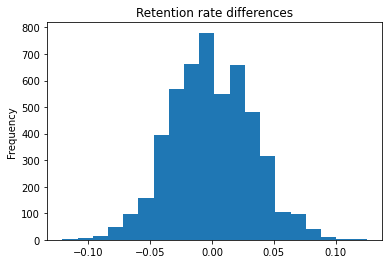

In [868]:
diff, p = permutation(df=one_diff, original_label_col='promo_value', retention_col='is_retained')

### Finally let's run the paired bootstrapping for each pair

We'll run choice(6,2) so we have 15 pairs in total to test. We choose a p value of 0.05. 

In [869]:
from itertools import combinations

combins = combinations([0, 1, 2, 3, 4, 5], 2)

all_pairs = list(combins)
all_pairs

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 4),
 (2, 5),
 (3, 4),
 (3, 5),
 (4, 5)]

Choose only unique customers and limit the columns to relevant ones

In [870]:
# Let's filter only customers with promo code 0 and 1 (when they first joined)
ready_for_bootstrap = df2[['customer','promo_value', 'is_retained']].reset_index(drop=True).drop_duplicates()

In [871]:
ready_for_bootstrap.sample(n=5)

customer  promo_value is_retained
18291  25308220886            4       False
653     6055506509            0       False
14093   6103696913            1       False
373    18945144944            0        True
7147    6046840946            0        True

In [872]:
for pair in all_pairs:
    
    #filter the dataframe son only two pairs are available
    filtered = ready_for_bootstrap[ready_for_bootstrap.promo_value.isin(pair)]
    
    print(f'Data points for each promo code is: {filtered.promo_value.value_counts().to_dict()}')
    
    # Run permutation
    diff, p = permutation(df=filtered, visualize=False, repetitions=1000)
    
    # Report of we can rule out null hypothesis
    if p< 0.05:
        print(f'>-----DIFFERENCE IS MEANINGFUL as p value is {p} < 0.05--------<')
    print('-----------------------------------------------\n')

Data points for each promo code is: {0: 7240, 1: 235}
original diff: -0.08581462325144001
Empirical p-val is: 0.006
>-----DIFFERENCE IS MEANINGFUL as p value is 0.006 < 0.05--------<
-----------------------------------------------

Data points for each promo code is: {0: 7240, 2: 235}
original diff: -0.021984836017397424
Empirical p-val is: 0.253
-----------------------------------------------

Data points for each promo code is: {0: 7240, 3: 237}
original diff: -0.08118225050702849
Empirical p-val is: 0.009
>-----DIFFERENCE IS MEANINGFUL as p value is 0.009 < 0.05--------<
-----------------------------------------------

Data points for each promo code is: {0: 7240, 4: 210}
original diff: -0.12735464351486453
Empirical p-val is: 0.0
>-----DIFFERENCE IS MEANINGFUL as p value is 0.0 < 0.05--------<
-----------------------------------------------

Data points for each promo code is: {0: 7240, 5: 112}
original diff: -0.09937845303867404
Empirical p-val is: 0.003
>-----DIFFERENCE IS MEANIN

**Conclusion**:

Differences between no promo and all others are too big to explain by chance. 

Among promo values, 2 has meaningful difference between 1, 3, 4 and 5
but there is no meaningful diffference between 3,5 or 4,5.
Promo 2 meaningful difference can be related to drop in retention between March - June 2019.

## RFM (Recency, Frequency, Monetary Value) Analysis

In [873]:
# For recency calculation we need a snapshot day, it generally one day after the last transaction
snapshot_date  = df.date_purchased_as_date.max() + datetime.timedelta(days=1)
snapshot_date

datetime.date(2020, 5, 12)

In [874]:
datamart = df.groupby(['customer']).agg({
    'date_purchased_as_date': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'count',
    'restaurant_total': 'sum'
}) \
    .rename(columns={
        'date_purchased_as_date': 'Recency',
        'order_id': 'Frequency',
        'restaurant_total': 'MonetaryValue'
})

In [875]:
# Let's look at a sample of few customers
datamart.sample(n=5)

Recency  Frequency  MonetaryValue
customer                                      
16887376190       86          5         237.07
23439913967      249          1          31.39
28481250599       68         10         554.96
14533016747      403          1           7.75
21405557075      150          1          15.05

In [730]:
recency_labels = range(4, 0, -1)
r_quartiles = pd.qcut(datamart['Recency'], 4, labels=recency_labels)
datamart = datamart.assign(R = r_quartiles.values)

In [737]:
freq_labels = range(1, 4)
monval_labels = range(1, 5)

In [745]:
f_quartiles = pd.qcut(datamart['Frequency'], 3, labels=freq_labels, duplicates='drop')
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels=monval_labels)

datamart = datamart.assign(F = f_quartiles.values)
datamart = datamart.assign(M = m_quartiles.values)

In [746]:
datamart

Recency  Frequency  MonetaryValue  R  M  F RFM_Segment  \
customer                                                                 
1920771353          171          1          46.42  2  2  1         212   
4042653893          176          6         139.09  2  4  3         234   
4555796885          318          1          29.78  1  1  1         111   
6033333473           88          1          12.24  3  1  1         311   
6036185756          275          1          44.75  1  2  1         112   
...                 ...        ...            ... .. .. ..         ...   
51227013587         149          4         168.28  2  4  3         224   
57523677443         154          3          66.21  2  2  2         222   
120495000000        366          2          56.42  1  2  1         112   
217278000000        363          1          16.84  1  1  1         111   
21118800000000      276          1          27.17  1  1  1         111   

                RFM_Score  
customer                   
1920771353              5  
4042653893              9  
4555796885              3  
6033333473              5  
6036185756              4  
...                   ...  
51227013587             8  
57523677443             6  
120495000000            4  
217278000000            3  
21118800000000          3  

[10295 rows x 8 columns]

In [747]:
join_rfm = lambda row:  str(int(row['R'])) + str(int(row['F'])) +  str(int(row['M']))

In [748]:
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)

In [749]:
datamart['RFM_Score'] = datamart[['R', 'F', 'M']].sum(axis=1)

In [750]:
datamart

Recency  Frequency  MonetaryValue  R  M  F RFM_Segment  \
customer                                                                 
1920771353          171          1          46.42  2  2  1         212   
4042653893          176          6         139.09  2  4  3         234   
4555796885          318          1          29.78  1  1  1         111   
6033333473           88          1          12.24  3  1  1         311   
6036185756          275          1          44.75  1  2  1         112   
...                 ...        ...            ... .. .. ..         ...   
51227013587         149          4         168.28  2  4  3         234   
57523677443         154          3          66.21  2  2  2         222   
120495000000        366          2          56.42  1  2  1         112   
217278000000        363          1          16.84  1  1  1         111   
21118800000000      276          1          27.17  1  1  1         111   

                RFM_Score  
customer                   
1920771353              5  
4042653893              9  
4555796885              3  
6033333473              5  
6036185756              4  
...                   ...  
51227013587             9  
57523677443             6  
120495000000            4  
217278000000            3  
21118800000000          3  

[10295 rows x 8 columns]

# Analyze RFM table

In [751]:
datamart.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
111    1237
434    1215
211     787
112     646
212     581
312     578
334     574
311     463
412     320
234     308
dtype: int64

Observation: Segment 111, which means churned (not recent), not really frequently used, and not so many times shopped (monetary value) customer is the segment with most common, ( this is the segment with least value)

But the second most common segment 434 is the best customers as they frequently and recently shopped with high monetary value.

In [752]:
datamart[datamart['RFM_Segment']=='434'].head()

Recency  Frequency  MonetaryValue  R  M  F RFM_Segment  RFM_Score
customer                                                                     
6036415163       32          7         271.71  4  4  3         434         11
6038458250       10         29        1219.16  4  4  3         434         11
6041564255        2          4         357.35  4  4  3         434         11
6042188795       13         12         321.85  4  4  3         434         11
6042694769       19         24         613.92  4  4  3         434         11

## Summary metrics per RFM score

In [757]:
datamart.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3          321.90      1.10         23.20  1237
4          233.80      1.30         35.40  1447
5          160.20      1.60         47.70  1342
6          123.00      2.00         67.20  1119
7           95.30      2.60         83.90  1084
8           98.20      3.60        121.70  1017
9           77.10      5.40        168.70   930
10          46.70      8.20        269.50   904
11          13.00     12.30        419.00  1215

In [759]:
def segment_cust(df):
    if df['RFM_Score'] >=9:
        return 'Gold'
    elif df['RFM_Score'] >=5:
        return 'Silver'
    else:
        return 'Bronze'

In [760]:
datamart['General_Segment'] = datamart.apply(segment_cust, axis=1)

In [762]:
datamart.groupby('General_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
})

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze           274.40      1.17         29.79  2684
Gold              42.53      8.98        298.31  3049
Silver           121.85      2.38         77.58  4562

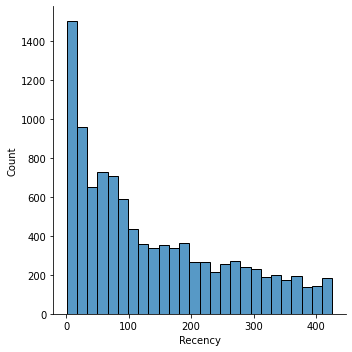

In [764]:
sns.displot(datamart['Recency'])

c:\users\aleks\onedrive\documents\api_work\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Frequency', ylabel='Density'>

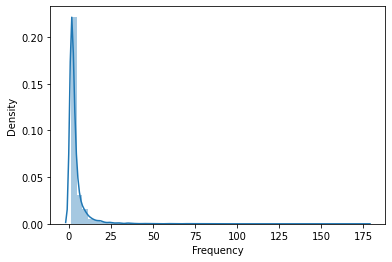

In [766]:
sns.distplot(datamart['Frequency'])

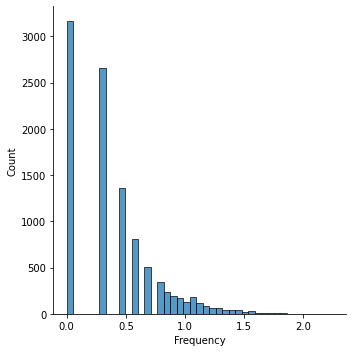

In [770]:
freq_log = np.log10(datamart['Frequency'])
sns.displot(freq_log)

In [772]:
from scipy.stats import boxcox
bcx_target, lam = boxcox(datamart["Frequency"])

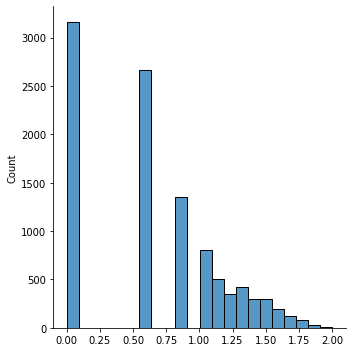

In [773]:
sns.displot(bcx_target)